In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1. Display TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# 2. Check for available physical devices
devices = tf.config.list_physical_devices()
print("\nPhysical devices found:")
for device in devices:
    print(f"- {device}")

if any("GPU" in str(device) for device in devices):
    print("\n✅ GPU is available and will be used for training!")
else:
    print("\nℹ️ Training will run on CPU.")

tf.random.set_seed(42)

/Users/darindor2101/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


TensorFlow version: 2.15.0

Physical devices found:
- PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

✅ GPU is available and will be used for training!


In [2]:
from sklearn.datasets import fetch_openml

# Load the French Motor Third-Party Liability dataset
print("Fetching data...")
df = fetch_openml(data_id=41214, as_frame=True, parser="pandas").frame

# Basic cleaning (consistent with Notebook 01)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)

# Feature selection
features = ['ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region']
df = df[features]

# Train/Test Split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
print(f"Data loaded. Train size: {len(df_train)}, Test size: {len(df_test)}")

Fetching data...
Data loaded. Train size: 542410, Test size: 135603


In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define feature groups
num_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
cat_features = ['Area', 'VehBrand', 'VehGas', 'Region']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ])

# Fit and transform
X_train = preprocessor.fit_transform(df_train)
X_test = preprocessor.transform(df_test)

# Prepare targets and exposure as float32 tensors
y_train = df_train['ClaimNb'].values.astype('float32')
y_test = df_test['ClaimNb'].values.astype('float32')
exp_train = df_train['Exposure'].values.astype('float32')
exp_test = df_test['Exposure'].values.astype('float32')

print(f"Preprocessing complete. X_train shape: {X_train.shape}")

Preprocessing complete. X_train shape: (542410, 46)


In [4]:
from tensorflow.keras import layers, models, backend as K

# 1. Final approach: Softplus activation for extreme stability
# Softplus is more stable than Exponential because it grows linearly for large x
input_features = layers.Input(shape=(X_train.shape[1],), name="feature_input")
input_exposure = layers.Input(shape=(1,), name="exposure_input")

x = layers.Dense(128, activation='relu')(input_features)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='relu')(x)
x = layers.BatchNormalization()(x)

# Use 'softplus' to ensure positive frequency without exponential explosion
predicted_rate = layers.Dense(1, activation='softplus', name="predicted_rate")(x)

# Multiply rate by exposure in the normal domain
final_output = layers.Multiply(name="total_claims_output")([predicted_rate, input_exposure])

model = models.Model(inputs=[input_features, input_exposure], outputs=final_output)

# 2. Compile with standard Poisson loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='poisson'
)

model.summary()

2026-02-06 11:18:30.312100: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2026-02-06 11:18:30.312312: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2026-02-06 11:18:30.312323: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 12.48 GB
2026-02-06 11:18:30.312652: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-06 11:18:30.312943: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ feature_input       │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      6,016 │ feature_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predicted_rate      │ (None, 1)         │         33 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exposure_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_claims_output │ (None, 1)         │          0 │ predicted_rate[0… │
│ (Multiply)          │                   │            │ exposure_input[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,281 (67.50 KB)

 Trainable params: 16,833 (65.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# Training the model
# We pass [X_train, exp_train] as inputs because our model has two input layers
history = model.fit(
    x=[X_train, exp_train],
    y=y_train,
    validation_data=([X_test, exp_test], y_test),
    epochs=100,
    batch_size=1024, # Large batch size for faster training on GPU
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


2026-02-06 11:18:31.212690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.3025 - val_loss: 0.2103
Epoch 2/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.2101 - val_loss: 0.2102
Epoch 3/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.2100 - val_loss: 0.2101
Epoch 4/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.2099 - val_loss: 0.2101
Epoch 5/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.2099 - val_loss: 0.2100
Epoch 6/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.2099 - val_loss: 0.2100
Epoch 7/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.2100 - val_loss: 0.2100
Epoch 8/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.2100 - val_loss: 0.2100
Epoch 9/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.2100 - val_loss: 0.2100
Epoch 10/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.2099 - val_loss: 0.2100
Epoch 11/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.2099 - val_loss: 0.2100
Epoch 12/100
530/530 ━━━━━━━━━━

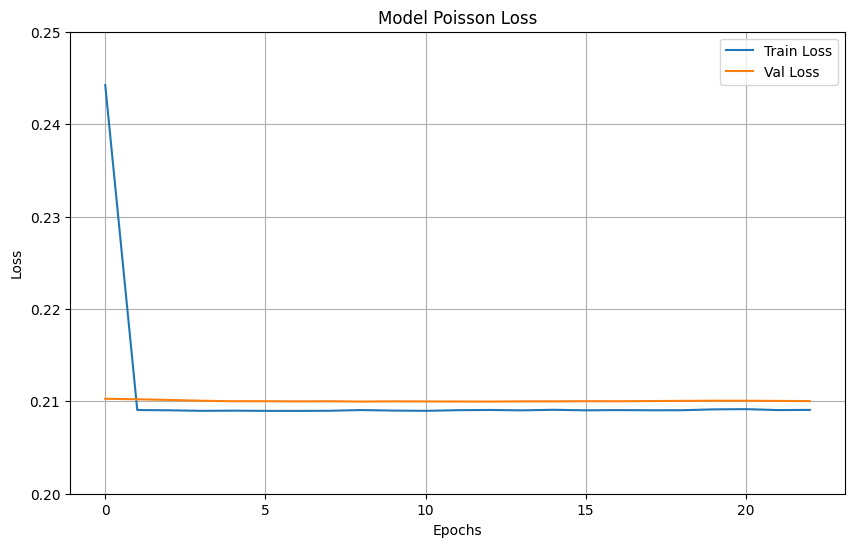

In [6]:
def plot_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Poisson Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    # We set a limit to the y-axis to see the convergence better
    plt.ylim(0.20, 0.25) 
    plt.show()

plot_history(history)

In [7]:
from sklearn.metrics import mean_poisson_deviance

# 1. Make predictions
# We need to pass both features and exposure to the model
y_pred_nn = model.predict([X_test, exp_test]).flatten()

# 2. Calculate Mean Poisson Deviance
# This is the industry standard metric for frequency models
nn_deviance = mean_poisson_deviance(y_test, y_pred_nn)

print(f"Neural Network Mean Poisson Deviance: {nn_deviance:.5f}")

# 3. Quick comparison (Reference from Notebook 01)
# Let's assume GLM benchmark was around 0.2240 and XGBoost was around 0.2135
# You can update these numbers with your actual results from NB 01
glm_benchmark = 0.2240 
improvement = (1 - (nn_deviance / glm_benchmark)) * 100
print(f"Improvement over GLM: {improvement:.2f}%")

4238/4238 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
Neural Network Mean Poisson Deviance: 0.32137
Improvement over GLM: -43.47%


In [8]:
import pandas as pd

model_layers = []

for layer in model.layers:
    # Try to get output_shape, fallback to input_shape, then to "N/A"
    try:
        shape = layer.output_shape
    except AttributeError:
        try:
            shape = layer.input_shape
        except AttributeError:
            shape = "N/A"
            
    model_layers.append({
        "Layer Name": layer.name,
        "Type": layer.__class__.__name__,
        "Shape": shape,
        "Trainable": layer.trainable
    })

df_layers = pd.DataFrame(model_layers)
print("\n--- Structural Overview ---")
print(df_layers.to_string(index=False))


--- Structural Overview ---
           Layer Name               Type Shape  Trainable
        feature_input         InputLayer   N/A       True
                dense              Dense   N/A       True
  batch_normalization BatchNormalization   N/A       True
              dropout            Dropout   N/A       True
              dense_1              Dense   N/A       True
batch_normalization_1 BatchNormalization   N/A       True
            dropout_1            Dropout   N/A       True
              dense_2              Dense   N/A       True
batch_normalization_2 BatchNormalization   N/A       True
       predicted_rate              Dense   N/A       True
       exposure_input         InputLayer   N/A       True
  total_claims_output           Multiply   N/A       True


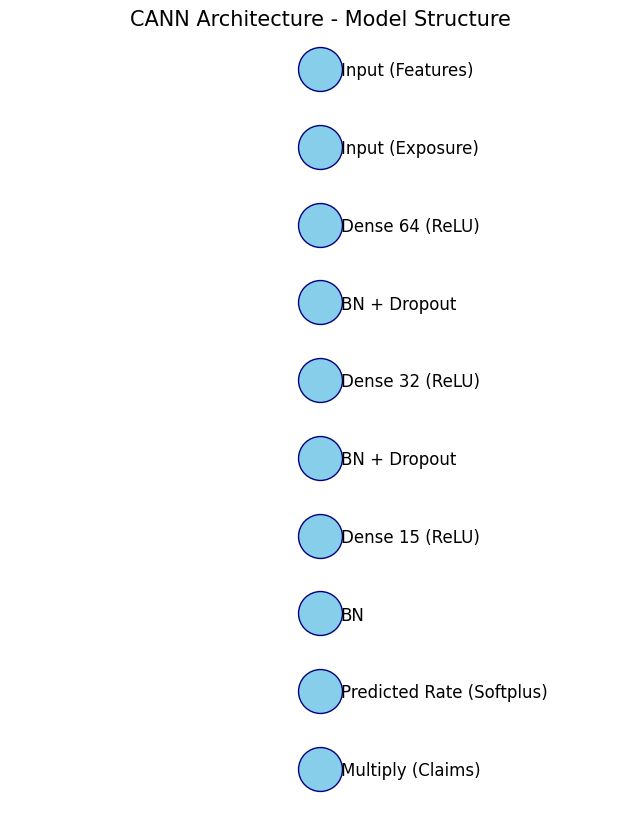

In [9]:
import matplotlib.pyplot as plt

# Creiamo una rappresentazione visuale semplice della struttura
plt.figure(figsize=(8, 10))
layers = ["Input (Features)", "Input (Exposure)", "Dense 64 (ReLU)", "BN + Dropout", 
          "Dense 32 (ReLU)", "BN + Dropout", "Dense 15 (ReLU)", "BN", 
          "Predicted Rate (Softplus)", "Multiply (Claims)"]
x = [1] * len(layers)
y = list(range(len(layers), 0, -1))

plt.scatter(x, y, s=1000, c='skyblue', edgecolors='navy')
for i, txt in enumerate(layers):
    plt.annotate(txt, (x[i], y[i]), textcoords="offset points", xytext=(15,-5), ha='left', fontsize=12)

plt.title("CANN Architecture - Model Structure", fontsize=15)
plt.axis('off')
plt.show()